# Trimming

This notebook will go through the workflow for the trimmomatic tool. This tool cleans FASTQ reads, offering a selection for multiple options within the command line. 

1. Compressing Files to run through Trimmomatic
2. An introduction to [Trimmomatic](https://carpentries-lab.github.io/metagenomics-analysis/03-trimming-filtering/index.html).


## File Prep -- Compressing to run files through Trimmomatic

Trimmomatic works on FAST files that are compressed with either gzip or bzip2. We'll be using gzip to get the .gz file extension we need. These files are massive so lets run a script to sbatch the compression job.

In [ ]:
!nano ~/scripts/gzip_untrimmedfiles.sh

In [ ]:
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --nodes=1             
#SBATCH --time=10:00:00   
#SBATCH --partition=standard
#SBATCH --account=bhurwitz
#SBATCH --array=0-46                           # needs to be the number of files we're assessing read quality
#SBATCH --output=Job-%a.out
#SBATCH --cpus-per-task=1                    # num CPUs per task
#SBATCH --mem=4G                             # total memory per node
 
# SLURM Inherits your environment. cd $SLURM_SUBMIT_DIR not needed
pwd; hostname; date
 
names=($(cat /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data/SRR_Acc_List.txt))
readdir="/xdisk/bhurwitz/YOUR_NAME/data"


gzip ${readdir}/${names[${SLURM_ARRAY_TASK_ID}]}_*.fastq

In [ ]:
!sbatch gzip_untrimmedfiles.sh

## Trimming .fastq Files

In order to run trimmomatic in a PE (paired-end) format we'll need two files. We have this as we used our other tools to split the file downloads to return *_1.fastq and *_2.fastq for each SRA. Our output will be presented with 4 output files (forward paired, forward unpaired, reverse paired and reverse unpaired). 

We'll be following along with the software carpentries workshop. We saw in our reports after running QC that we had no adapters present in the reads, so we can skip the Illumina adapter removal. If we did need to run an adapter trim we would use the FastQC report to determine which and some info from the manual to help pick.

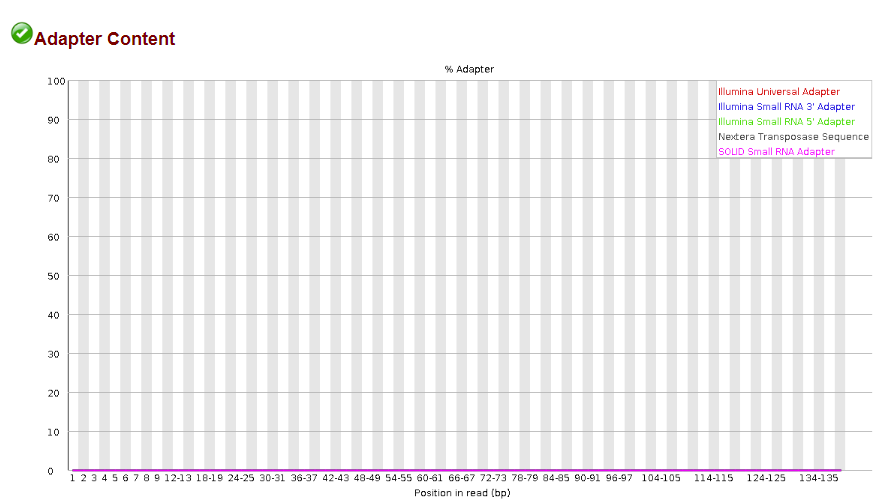

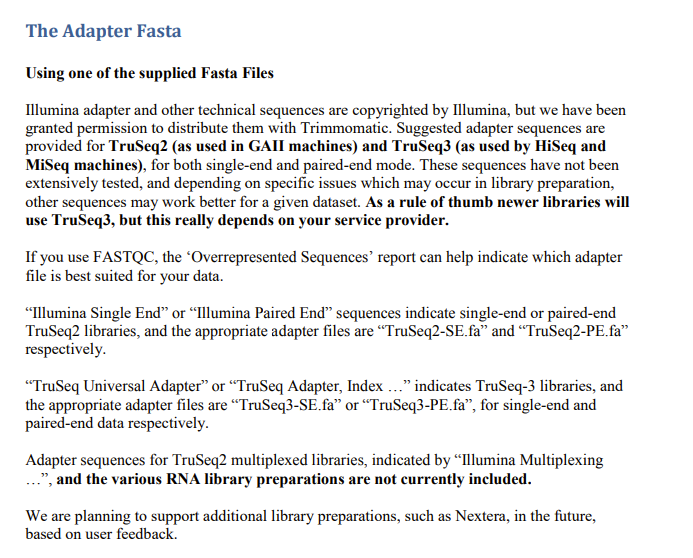

In [ ]:
!nano trimmomatic_fastq.sh

### Initial Data Management
Trimmomatic outputs four files based on the initial two paired-end fastq files we give it. Let's set up some output locations so the script can organize our data as it runs.


In [ ]:
!mkdir /xdisk/bhurwitz/YOUR_NAME/trimming/trimmed_reads
!mkdir /xdisk/bhurwitz/YOUR_NAME/trimming/untrimmed_reads

In [ ]:
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --nodes=1             
#SBATCH --time=10:00:00   
#SBATCH --partition=standard
#SBATCH --account=bhurwitz
#SBATCH --array=0-46                           # needs to be the number of files we're assessing read quality
#SBATCH --output=Job-%a.out
#SBATCH --cpus-per-task=1                    # num CPUs per task
#SBATCH --mem=4G                             # total memory per node
 
# SLURM Inherits your environment. cd $SLURM_SUBMIT_DIR not needed
pwd; hostname; date
 
names=($(cat /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data/SRR_Acc_List.txt))
readdir="/xdisk/bhurwitz/YOUR_NAME/data"
trimdir="/xdisk/bhurwitz/YOUR_NAME/trimming/trimmed_reads"
untrimdir="/xdisk/bhurwitz/YOUR_NAME/trimming/untrimmed_reads"

apptainer run /contrib/singularity/shared/bhurwitz/trimmomatic:0.39--hdfd78af_2.sif trimmomatic PE \
    ${readdir}/${names[${SLURM_ARRAY_TASK_ID}]}_1.fastq.gz ${readdir}/${names[${SLURM_ARRAY_TASK_ID}]}_2.fastq.gz \
    ${trimdir}/${names[${SLURM_ARRAY_TASK_ID}]}_1.fastq.gz ${untrimdir}/${names[${SLURM_ARRAY_TASK_ID}]}_1.fastq.gz \
    ${trimdir}/${names[${SLURM_ARRAY_TASK_ID}]}_2.fastq.gz ${untrimdir}/${names[${SLURM_ARRAY_TASK_ID}]}_2.fastq.gz \
    SLIDINGWINDOW:4:20
    

In [ ]:
!sbatch trimmomatic_fastq.sh

#### Output Files

Trimming produces four output files from two input files. It separates the trimmed segments from the "orphaned" segments.

## QC Check

It's always a good idea to run your trimmed fastq files back through QC to check how the data was trimmed. You should check for any failures to be cleared and any other warnings/previous passes to something new.

## Data Management / Cleanup

Trimmomatic makes four output files -- it'll be important to continue practicing good data management and isolating trimmed vs untrimmed into specific directories. As you begin to create a better sbatch file you can chain everything together, including sending output files to specific directories!